In [1]:
import os
from PIL import Image
import numpy as np
 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt

In [2]:
import os

def remove_ds_store(data_folder):
    """
    Remove .DS_Store files from the dataset directories.
    """
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file == '.DS_Store':
                file_path = os.path.join(root, file)
                print(f"Removing {file_path}")
                os.remove(file_path)

# Specify the processed data folder
data_folder = 'processed_data'
remove_ds_store(data_folder)


In [3]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import glob

# Data transformation pipeline for training, validation, and testing

resize_size = 384
crop_size = 380

train_transform = transforms.Compose([
        transforms.Resize(resize_size), #Resize the image for uniformity
        transforms.CenterCrop(crop_size),  # Crop to the required size from the center
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally to augment data to avoid overfitting
        transforms.RandomRotation(15), # Randomly rotate images to a 15 degree to augment data to avoid overfitting
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # Normalize images with mean and std dev of ImageNet
    ])

val_transform = transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

test_transform = transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

 

# Since images are already processed, we only convert them to tensors
#transform = transforms.Compose([
    #transforms.ToTensor()  # Convert images to PyTorch tensors
#])

# Custom dataset to load image data manually from class folders
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        """
        Args:
            image_paths (list): List of file paths to images.
            transform (callable, optional): Optional transform to apply to images.
        """
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # Ensure 3-channel RGB images
        
        # Extract the label from the folder name (e.g., 'Blue', 'Black', 'Green', 'TTR')
        label = self.get_label_from_path(image_path)
        
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def get_label_from_path(self, image_path):
        """
        Extracts the label from the folder name in the image path.
        Assumes the folder structure is like data/train/Blue/image1.jpg.
        
        Args:
            image_path (str): File path to the image.
        
        Returns:
            label (int): Numeric label for the class ('Blue', 'Black', 'Green', 'TTR').
        """
        folder_name = os.path.basename(os.path.dirname(image_path))
        class_mapping = {'Blue': 0, 'Black': 1, 'Green': 2, 'TTR': 3}
        return class_mapping.get(folder_name, -1)  # Default to -1 if the class is unknown

def load_images_from_folder(folder):
    """
    Loads image file paths from a folder, ignoring non-image files like .DS_Store.

    Args:
        folder (str): Folder path containing class subfolders.
    
    Returns:
        list: List of valid image file paths.
    """
    valid_extensions = ('.jpg', '.jpeg', '.png')
    image_paths = []
    
    # Traverse the folder and all subfolders
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(valid_extensions) and not file.startswith('.'):
                image_paths.append(os.path.join(root, file))
    
    return image_paths

def load_data_separately(data_folder, batch_size=32):
    """
    Loads image data from each class separately, merges them, and avoids invalid files.

    Args:
        data_folder (str): Folder containing 'train', 'test', 'validation' subfolders.
        batch_size (int): Batch size for DataLoader.
    
    Returns:
        DataLoader objects for train, test, and validation datasets.
    """
    # Load images from each dataset folder
    train_images = load_images_from_folder(os.path.join(data_folder, 'train'))
    test_images = load_images_from_folder(os.path.join(data_folder, 'test'))
    val_images = load_images_from_folder(os.path.join(data_folder, 'validation'))

    # Create custom datasets
    train_data = CustomImageDataset(train_images, transform=train_transform)
    test_data = CustomImageDataset(test_images, transform=test_transform)
    val_data = CustomImageDataset(val_images, transform=val_transform)

    # Create DataLoader objects for each dataset
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

# Specify the processed data folder
data_folder = 'C:/marzi_data/processed_data'  # Path to your processed data folder

# Load the data
train_loader, test_loader, val_loader = load_data_separately(data_folder, batch_size=32)

# Example to see the size of the datasets
print(f'Train dataset size: {len(train_loader.dataset)}')
print(f'Test dataset size: {len(test_loader.dataset)}')
print(f'Validation dataset size: {len(val_loader.dataset)}')


Train dataset size: 10200
Test dataset size: 3431
Validation dataset size: 1800


# Number Of Data In Train, Validation, and Test

In [ ]:
import os
from collections import Counter

# Function to count the number of images and their classes in a DataLoader
def count_classes_and_images(loader):
    """
    Count the total number of images and the distribution of labels in the DataLoader.

    Args:
        loader (DataLoader): DataLoader object containing images and labels.

    Returns:
        total_images (int): Total number of images in the DataLoader.
        class_distribution (dict): Dictionary of label counts for each class.
    """
    total_images = 0
    labels = []

    for _, label in loader:
        total_images += label.size(0)
        labels.extend(label.tolist())

    class_distribution = dict(Counter(labels))
    return total_images, class_distribution

# Load the data (assuming load_data_separately function exists)
train_loader, test_loader, val_loader = load_data_separately(data_folder, batch_size=32)

# Count and print details for each dataset
train_images, train_class_distribution = count_classes_and_images(train_loader)
test_images, test_class_distribution = count_classes_and_images(test_loader)
val_images, val_class_distribution = count_classes_and_images(val_loader)

# Print results
print(f"Train dataset size: {train_images}, Class distribution: {train_class_distribution}")
print(f"Test dataset size: {test_images}, Class distribution: {test_class_distribution}")
print(f"Validation dataset size: {val_images}, Class distribution: {val_class_distribution}")


Train dataset size: 10200, Class distribution: {0: 4355, 2: 1991, 1: 2111, 3: 1743}
Test dataset size: 3431, Class distribution: {1: 695, 0: 1085, 2: 799, 3: 852}
Validation dataset size: 1800, Class distribution: {1: 372, 0: 768, 2: 352, 3: 308}


## Training the Model

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device", device)

device cuda:0


In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import numpy as np
from torch import nn
import timm  # For the EfficientNet model

# Assuming train_loader, val_loader, and test_loader are already defined
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

# Dataset sizes for calculating loss/accuracy
dataset_sizes = {
    'train': len(train_loader.dataset),
    'val': len(val_loader.dataset)
}

# Define device (use GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to train the model
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=200):
    since = time.time()
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # Initialize the best accuracy to zero

    # Loop over the dataset multiple times based on the number of epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Storing true and predicted labels to calculate metrics later
            all_labels = []
            all_preds = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Append data for metrics calculation
                all_labels.append(labels.cpu().numpy())
                all_preds.append(preds.cpu().numpy())

            # Calculate loss and accuracy for the current epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Saving history for plots
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
                train_loss_history.append(epoch_loss)
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Calculate and print metrics
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return model, best_acc, train_loss_history, train_acc_history, val_loss_history, val_acc_history


# Loading the EfficientNet_b4 model from timm library
model = timm.create_model('efficientnet_b4', pretrained=True)

# Freeze all the layers except the final one
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes (4 in your case)
num_ftrs = model.classifier.in_features

# Add a Dropout layer and a new final Linear layer with 4 outputs (for Blue, Black, Green, TTR)
#model.classifier = nn.Sequential(
    #nn.Dropout(0.2),
    #nn.Linear(num_ftrs, 4)
#)

# Add a Dropout layer, a hidden Linear layer, ReLU activation, and a new final Linear layer with 4 outputs
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, 256),  # Hidden layer with 256 units
    nn.ReLU(),                 # Activation function for hidden layer
    nn.Dropout(0.2),           # Additional dropout layer for regularization
    nn.Linear(256, 4)          # Final layer with 4 outputs
)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

# Set up the loss function (CrossEntropy for classification)
criterion = nn.CrossEntropyLoss()

# Set up the optimizer (Adam with learning rate for feature extraction)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Set up a learning rate scheduler to adjust learning rate over epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)

# Train the model
model, best_acc, train_loss_history_extract, train_acc_history_extract, val_loss_history_extract, val_acc_history_extract = train_model(
    model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=50
)

# Now the model is trained, and you can check the results (best accuracy, loss, etc.)


Epoch 0/49
----------
train Loss: 0.8304 Acc: 0.6688
val Loss: 0.7465 Acc: 0.7050

Epoch 1/49
----------
train Loss: 0.6799 Acc: 0.7327
val Loss: 0.6837 Acc: 0.7378

Epoch 2/49
----------
train Loss: 0.6355 Acc: 0.7541
val Loss: 0.6747 Acc: 0.7456

Epoch 3/49
----------
train Loss: 0.6004 Acc: 0.7674
val Loss: 0.6550 Acc: 0.7528

Epoch 4/49
----------
train Loss: 0.5740 Acc: 0.7736
val Loss: 0.6647 Acc: 0.7439

Epoch 5/49
----------
train Loss: 0.5301 Acc: 0.7964
val Loss: 0.6410 Acc: 0.7533

Epoch 6/49
----------
train Loss: 0.5289 Acc: 0.7943
val Loss: 0.6349 Acc: 0.7617

Epoch 7/49
----------
train Loss: 0.5267 Acc: 0.7991
val Loss: 0.6347 Acc: 0.7578

Epoch 8/49
----------
train Loss: 0.5112 Acc: 0.8054
val Loss: 0.6320 Acc: 0.7617

Epoch 9/49
----------
train Loss: 0.5176 Acc: 0.8037
val Loss: 0.6322 Acc: 0.7633

Epoch 10/49
----------
train Loss: 0.5187 Acc: 0.8020
val Loss: 0.6329 Acc: 0.7589

Epoch 11/49
----------
train Loss: 0.5089 Acc: 0.8034
val Loss: 0.6268 Acc: 0.7578

Ep

## Store the trained model

In [ ]:
# save the model under the name of fine_tuned_model.pth
torch.save(model, 'fine_tuned_model.pth')

## Save the Logs and Plotting Accuracy and Loss of Train and Validation

In [ ]:
# Concatenate the histories
train_loss_history = train_loss_history_extract 
val_loss_history = val_loss_history_extract 
train_acc_history = train_acc_history_extract
val_acc_history = val_acc_history_extract


In [ ]:
# Convert tensors to lists or floats for JSON serialization
results = {
    'train_loss_history': train_loss_history.tolist() if hasattr(train_loss_history, 'tolist') else train_loss_history,
    'val_loss_history': val_loss_history.tolist() if hasattr(val_loss_history, 'tolist') else val_loss_history,
    'train_acc_history': train_acc_history.tolist() if hasattr(train_acc_history, 'tolist') else train_acc_history,
    'val_acc_history': val_acc_history.tolist() if hasattr(val_acc_history, 'tolist') else val_acc_history,
    'best_acc': float(best_acc) if hasattr(best_acc, 'item') else best_acc
}

# Save the results to a file
import json

results_file = 'results.json'
with open(results_file, 'w') as file:
    json.dump(results, file)


## Read results.json

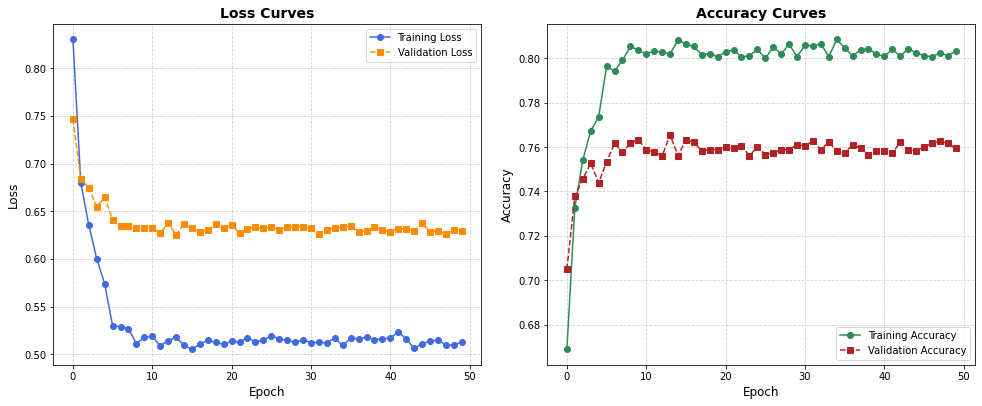

In [1]:
# read the results.json file and construct train_loss_history, val_loss_history, train_acc_history, val_acc_history, and best_acc
import json
import matplotlib.pyplot as plt
# Load the results from the JSON file
with open('results.json', 'r') as file:
    results = json.load(file)

# Extract the results
train_loss_history = results['train_loss_history']
val_loss_history = results['val_loss_history']
train_acc_history = results['train_acc_history']
val_acc_history = results['val_acc_history']
best_acc = results['best_acc']

# Customize the plots
plt.figure(figsize=(14, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, color='royalblue', linestyle='-', marker='o', label='Training Loss')
plt.plot(val_loss_history, color='darkorange', linestyle='--', marker='s', label='Validation Loss')
plt.title('Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, color='seagreen', linestyle='-', marker='o', label='Training Accuracy')
plt.plot(val_acc_history, color='firebrick', linestyle='--', marker='s', label='Validation Accuracy')
plt.title('Accuracy Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show plot
plt.tight_layout(pad=2.0)
plt.show()


## Test Model

In [5]:
# Load the model
import torch

model = torch.load('fine_tuned_model.pth')

In [6]:
# Switch model to evaluation mode
model.eval() 
true_labels = []
predicted_labels = []

with torch.no_grad(): # Not updating the gradient
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Accuracy Per Class of Test 

In [7]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=['Blue', 'Black', 'Green', 'TTR']))


              precision    recall  f1-score   support

        Blue       0.63      0.80      0.71      1085
       Black       0.57      0.39      0.46       695
       Green       0.72      0.84      0.78       799
         TTR       0.71      0.55      0.62       852

    accuracy                           0.66      3431
   macro avg       0.66      0.64      0.64      3431
weighted avg       0.66      0.66      0.65      3431



In [8]:
# print accuracy in a better way
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 66.37%


## Confusion matrix on test

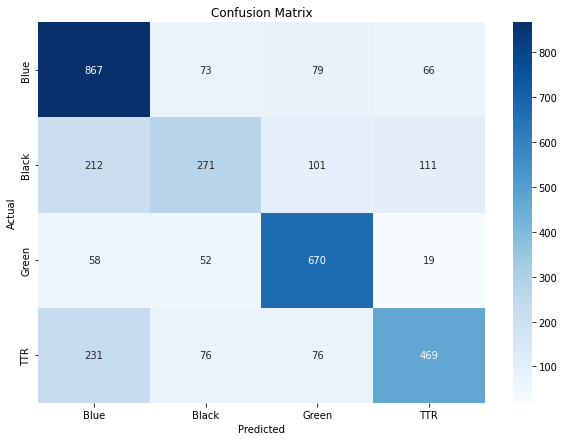

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
 
# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Blue', 'Black', 'Green', 'TTR'], yticklabels=['Blue', 'Black', 'Green', 'TTR'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()